In [1]:
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt

In [2]:
#CIFAR10 Dataset
data_set = datasets.CIFAR10(root="./data", download=False, transform=transforms.Compose([
    transforms.Resize(64),transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),]))
data_loader = torch.utils.data.DataLoader(data_set, batch_size = 128, shuffle=True, num_workers=2)

In [3]:
#parameters
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# noise_input dimension
noise_dimension = 100 
# real images label
real_value = 1 
# fake images label
fake_value = 0 

# Set torch random seed
rand_seed = random.randint(10, 100000)
random.seed(rand_seed)
torch.manual_seed(rand_seed)

In [4]:
# initializing the weights to discriminator and generator
def weights_initialize(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [5]:
#Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, passed_input):
        discriminator_output = self.main(passed_input)
        return discriminator_output.view(-1, 1).squeeze(1)

In [6]:
#Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(noise_dimension, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, passed_input):
        generator_output = self.main(passed_input)
        return generator_output

In [7]:
# Creating Generator and Discriminator and apply initial weights
discriminator = Discriminator().to(device)
generator = Generator().to(device)
discriminator.apply(weights_initialize)
generator.apply(weights_initialize)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [8]:
# setup optimizer for Generator and Discriminator
generator_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
disriminator_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
criterion = nn.BCELoss()

# More parameters for training and storing values
noise = torch.randn(128, noise_dimension, 1, 1, device=device)
gen_loss_list = []
dis_loss_list = []
counter = 0
counter_list = []

In [9]:
# Training for Discriminator and Generator
num_epochs = 10
for epoch in range(num_epochs):
    for i, data in enumerate(data_loader, 0):
        counter += 1
        counter_list.append(counter)
        
        # Updating discriminator with real images
        real_data = data[0].to(device)
        size_of_batch = real_data.size(0)
        labels_tensor = torch.full((size_of_batch,), real_value, device = device).float()
        discriminator.zero_grad()
        dis_output = discriminator(real_data ).float()
        dis_real_error = criterion(dis_output, labels_tensor)
        dis_real_error.backward()
        dis_real_output_mean = dis_output.mean().item()

        # Updating discriminator with fake images
        labels_tensor.fill_(fake_value).float()
        noise = torch.randn(size_of_batch, noise_dimension, 1, 1, device=device)
        fake_data = generator(noise)
        dis_output = discriminator(fake_data.detach()).float()
        dis_fake_error = criterion(dis_output, labels_tensor)
        dis_fake_error.backward()
        dis_fake_output_mean = dis_output.mean().item()
        disriminator_optimizer.step()
        final_dis_error = dis_real_error + dis_fake_error
        dis_loss_list.append(final_dis_error.item())
        

        # Update Generator 
        labels_tensor.fill_(real_value).float()
        generator.zero_grad()
        gen_output = discriminator(fake_data).float()
        gen_error = criterion(gen_output, labels_tensor)
        gen_loss_list.append(gen_error.item())
        gen_error.backward()
        gen_output_mean = gen_output.mean().item()
        generator_optimizer.step()

        
        print('[%d/%d][%d/%d] DisLoss: %.4f GenLoss: %.4f D(x): %.4f D(G(z)): %.4f / %.4f' % 
              (epoch, num_epochs, i, len(data_loader), final_dis_error.item(), 
               gen_error.item(), dis_real_output_mean, dis_fake_output_mean, gen_output_mean ))
        
    #Store images 
    fake_data = generator(noise)
    vutils.save_image(real_data,'DCganOutput/real_samples.png',normalize=True)
    vutils.save_image(fake_data.detach(),'DCganOutput/fake_samples_epoch_%03d.png' % (epoch), normalize=True)

[0/10][0/391] DisLoss: 1.7002 GenLoss: 5.4310 D(x): 0.4889 D(G(z)): 0.5264 / 0.0059
[0/10][1/391] DisLoss: 1.1932 GenLoss: 5.6178 D(x): 0.6975 D(G(z)): 0.4652 / 0.0056
[0/10][2/391] DisLoss: 1.1972 GenLoss: 5.6451 D(x): 0.6546 D(G(z)): 0.4062 / 0.0060
[0/10][3/391] DisLoss: 1.2107 GenLoss: 5.9028 D(x): 0.6640 D(G(z)): 0.3787 / 0.0041
[0/10][4/391] DisLoss: 1.0427 GenLoss: 6.7637 D(x): 0.7423 D(G(z)): 0.4199 / 0.0019
[0/10][5/391] DisLoss: 0.9020 GenLoss: 7.1486 D(x): 0.7245 D(G(z)): 0.3194 / 0.0014
[0/10][6/391] DisLoss: 0.8970 GenLoss: 6.7266 D(x): 0.6713 D(G(z)): 0.2605 / 0.0020
[0/10][7/391] DisLoss: 1.1392 GenLoss: 8.6469 D(x): 0.7287 D(G(z)): 0.4281 / 0.0004
[0/10][8/391] DisLoss: 0.5414 GenLoss: 7.6787 D(x): 0.7740 D(G(z)): 0.1640 / 0.0009
[0/10][9/391] DisLoss: 0.8896 GenLoss: 9.4498 D(x): 0.7739 D(G(z)): 0.3538 / 0.0002
[0/10][10/391] DisLoss: 0.6387 GenLoss: 7.0987 D(x): 0.7156 D(G(z)): 0.0794 / 0.0014
[0/10][11/391] DisLoss: 0.9048 GenLoss: 11.5520 D(x): 0.8865 D(G(z)): 0.479

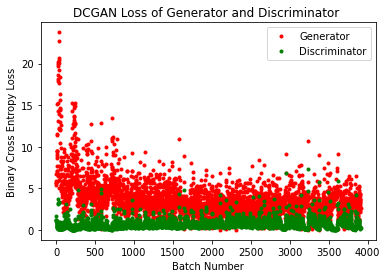

In [11]:
#loss of the generator and the descriminator
plt.plot(counter_list, gen_loss_list, 'r.', label='Generator')
plt.plot(counter_list, dis_loss_list, 'g.', label='Discriminator')
plt.title("DCGAN Loss of Generator and Discriminator ")
plt.xlabel("Batch Number")
plt.ylabel("Binary Cross Entropy Loss")
plt.legend(loc="best")
plt.show()